# Crosswalk Detection using aerial imagery




 Er. Yogesh Regmi

# Load libraries and prepare the dataset

In [1]:
#Import the required Libraries
from osgeo import osr
import os
import numpy as np
from osgeo import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
import tensorflow as tf
from keras import layers,models,losses
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.losses import mean_squared_error
from keras.layers import LeakyReLU
import pickle
import matplotlib.pyplot as plt 
import sys
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.chdir('d:')

In [3]:
#Define File directories
Data_folder = '/fiver_dl'
IMAGE_PATH = os.path.join(Data_folder, "image")
LABEL_PATH = os.path.join(Data_folder, "label")

#Load and prepare the required dataset

In [4]:
#Create list of the VHR images 
image_list={}
for f in sorted(os.listdir(IMAGE_PATH)):
    fdir = os.path.join(IMAGE_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        image_data=gdal.Open(fdir)
        bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
        image_list[imgtype] = np.stack(bands, axis=2)

In [5]:
#Create list of Lables
label_list={}
for f in sorted(os.listdir(LABEL_PATH)):
    fdir = os.path.join(LABEL_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        label_data=gdal.Open(fdir)
        bands = [label_data.GetRasterBand(i+1).ReadAsArray() for i in range(label_data.RasterCount)]
        label_list[imgtype] = np.stack(bands, axis=2)

C:\Users\MCSC\AppData\Local\Temp\ipykernel_14648\870033620.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


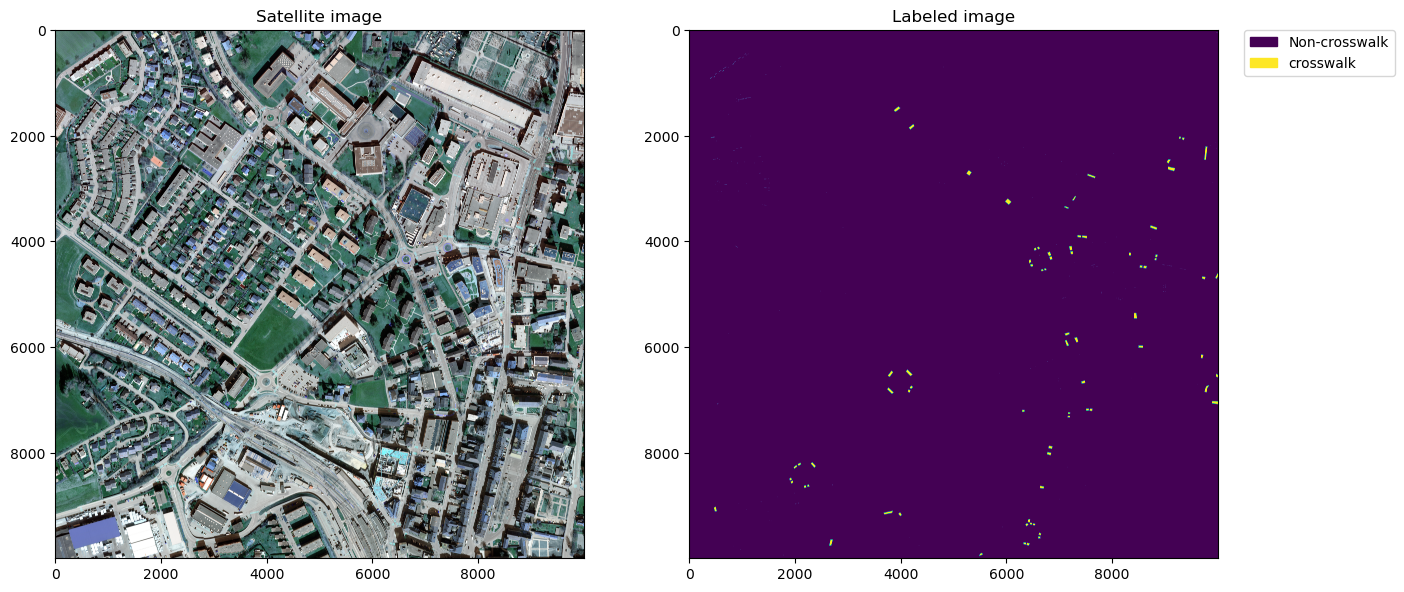

In [6]:


#visualize both images 
sample_image="3"
sample_label="3"

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["Non-crosswalk", "crosswalk"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(image_list[sample_image],label_list[sample_label])


In [7]:
bands=image_list["3"].shape[-1]

In [8]:
image_list.keys()

dict_keys(['3'])

In [9]:
#convert data into smaller patches and keras usable formats

PATCHSIZE = 256
NBANDS = image_list["3"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas = list(image_list.keys())
for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

In [10]:
len(Ytrain[Ytrain==1])

218108

In [11]:
len(Ytrain[Ytrain==0])

99462148

In [12]:
      #Check the percentage of crosswalk pixels with respect to non-crosswalk pixels
ls_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
nonls_px=len(Ytrain[Ytrain==0])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
print("Pixel percentage of crosswalk = " + str(ls_px* 100)) #We can observe that the percentage of landslide pixels are really less (<10%)
print("Pixel percentage of non-crosswalk = " + str(nonls_px* 100)) 

Pixel percentage of crosswalk = 0.21880762425008216
Pixel percentage of non-crosswalk = 99.78119237574991


In [13]:
#check the number of patches from single image
len(Xtrain)
len(Ytrain)

1521

C:\Users\MCSC\AppData\Local\Temp\ipykernel_14648\870033620.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


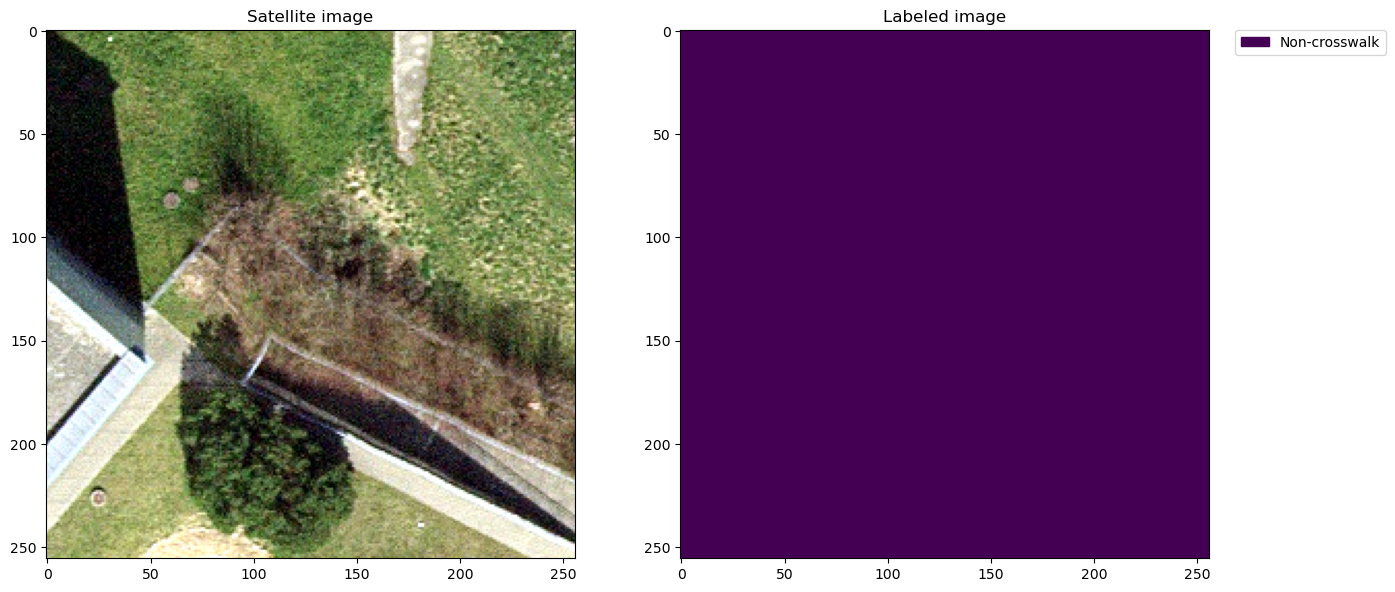

In [14]:
#Visualize the Patches of Image
PATCH_NO = 100
visualize_data(Xtrain[PATCH_NO],Ytrain[PATCH_NO])

# Model generation (FCN) and training phase

In [15]:
filt = [16,32,64,128,256]
def downward_conv(inputTensor, numFilters, act = 'relu', p = 'same'):
  down = layers.Conv2D(filters = numFilters, kernel_size = (3,3), strides = 1, padding = p)(inputTensor)
  down = layers.BatchNormalization()(down)
  down = layers.Activation(act)(down)
  down = layers.Dropout(0.15)(down)
  down = layers.Conv2D(filters = numFilters, kernel_size = (3,3), strides = 1, padding = p)(down)
  down = layers.BatchNormalization()(down)
  down = layers.Activation(act)(down)
  down = layers.Dropout(0.15)(down)
  pool = layers.MaxPool2D(pool_size = (2,2), strides = (2,2))(down)
  return down, pool

def bottleneck(inputTensor, numFilters, act = 'relu', p = 'same'):
  mid = layers.Conv2D(filters = numFilters, kernel_size = (3,3), strides = 1, padding = p)(inputTensor)
  mid = layers.BatchNormalization()(mid)
  mid = layers.Activation(act)(mid)  
  mid = layers.Dropout(0.15)(mid)
  mid = layers.Conv2D(filters = numFilters, kernel_size = (3,3), strides = 1, activation = act, padding = p)(mid)
  mid = layers.BatchNormalization()(mid)
  mid = layers.Activation(act)(mid)
  mid = layers.Dropout(0.15)(mid)
  return mid

def upward_conv(inputTensor, correspondingDownTensor, numFilters, act = 'relu', p = 'same'):
  up = layers.Conv2DTranspose(filters = numFilters, kernel_size = (2,2), strides = (2,2), padding = p)(inputTensor)
  up = layers.concatenate([correspondingDownTensor,up],axis=-1)
  up = layers.BatchNormalization()(up)
  up = layers.Activation(act)(up)
  up = layers.Conv2D(filters = numFilters, kernel_size = (3,3), strides = 1, padding = p)(up)
  up = layers.BatchNormalization()(up)
  up = layers.Activation(act)(up)
  up = layers.Dropout(0.15)(up)
  up = layers.Conv2D(filters = numFilters, kernel_size = (3,3), strides = 1, padding = p)(up)
  up = layers.BatchNormalization()(up)
  up = layers.Activation(act)(up)
  up = layers.Dropout(0.15)(up)
  return up

def unet():
  start = layers.Input(shape = ([256, 256, 3]))   
  down_step1, pool1 = downward_conv(start, filt[0])
  down_step2, pool2 = downward_conv(pool1, filt[1])
  down_step3, pool3 = downward_conv(pool2, filt[2])
  down_step4, pool4 = downward_conv(pool3, filt[3])

  middle = bottleneck(pool4, filt[4])

  up_step1 = upward_conv(middle, down_step4, filt[3])
  up_step2 = upward_conv(up_step1, down_step3, filt[2])
  up_step3 = upward_conv(up_step2, down_step2, filt[1])
  up_step4 = upward_conv(up_step3, down_step1, filt[0])

  output = layers.Conv2D(filters = 1, kernel_size = (1,1), activation = 'sigmoid', padding = 'same')(up_step4)
  
  model = models.Model(inputs = start, outputs = [output])
  
  

  model.compile(
      optimizer='adam',
      loss=mean_squared_error,
      metrics='accuracy')
  
  return model

UNet = unet()

In [16]:
History = UNet.fit(Xtrain,Ytrain,epochs=1,verbose=2)

48/48 - 1112s - loss: 0.1046 - accuracy: 0.9242 - 1112s/epoch - 23s/step


In [47]:
UNet.save(r'D:\ml\image\model.h5')

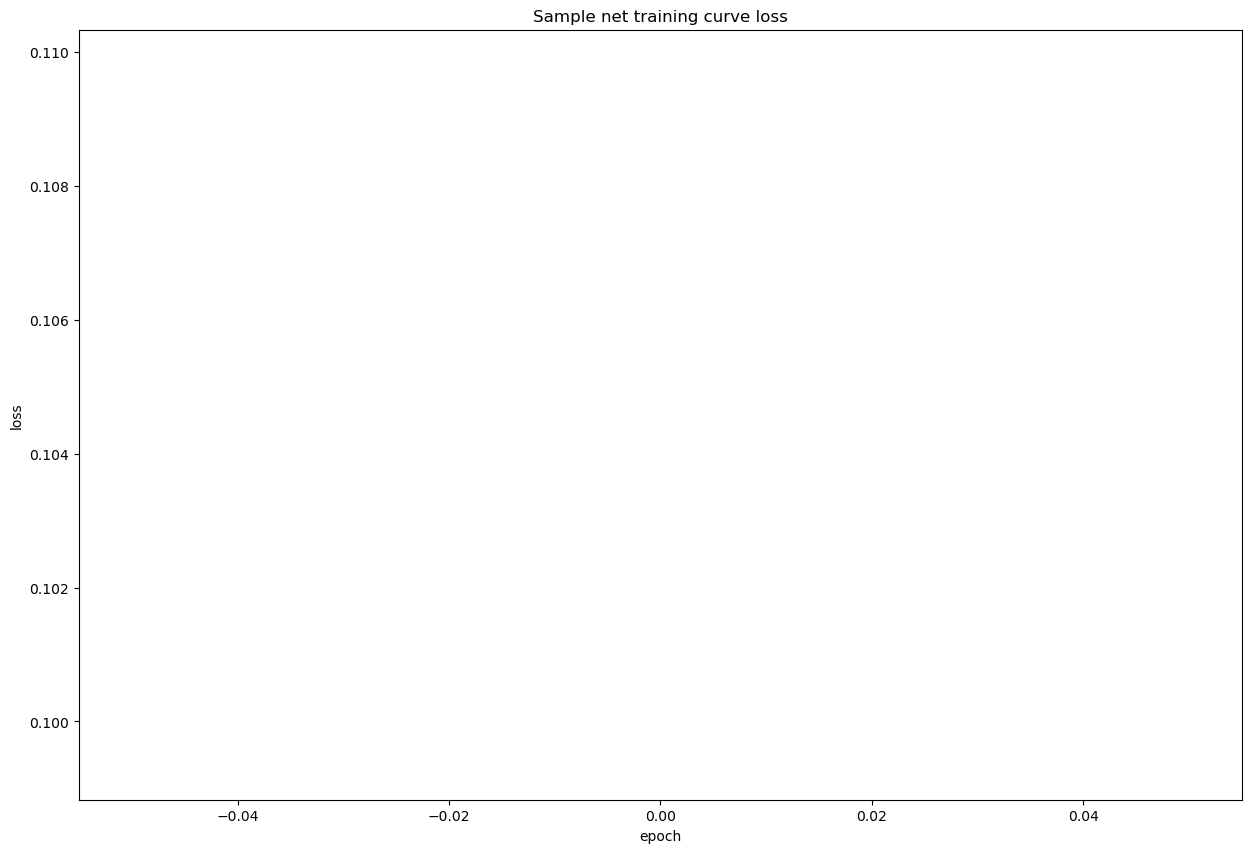

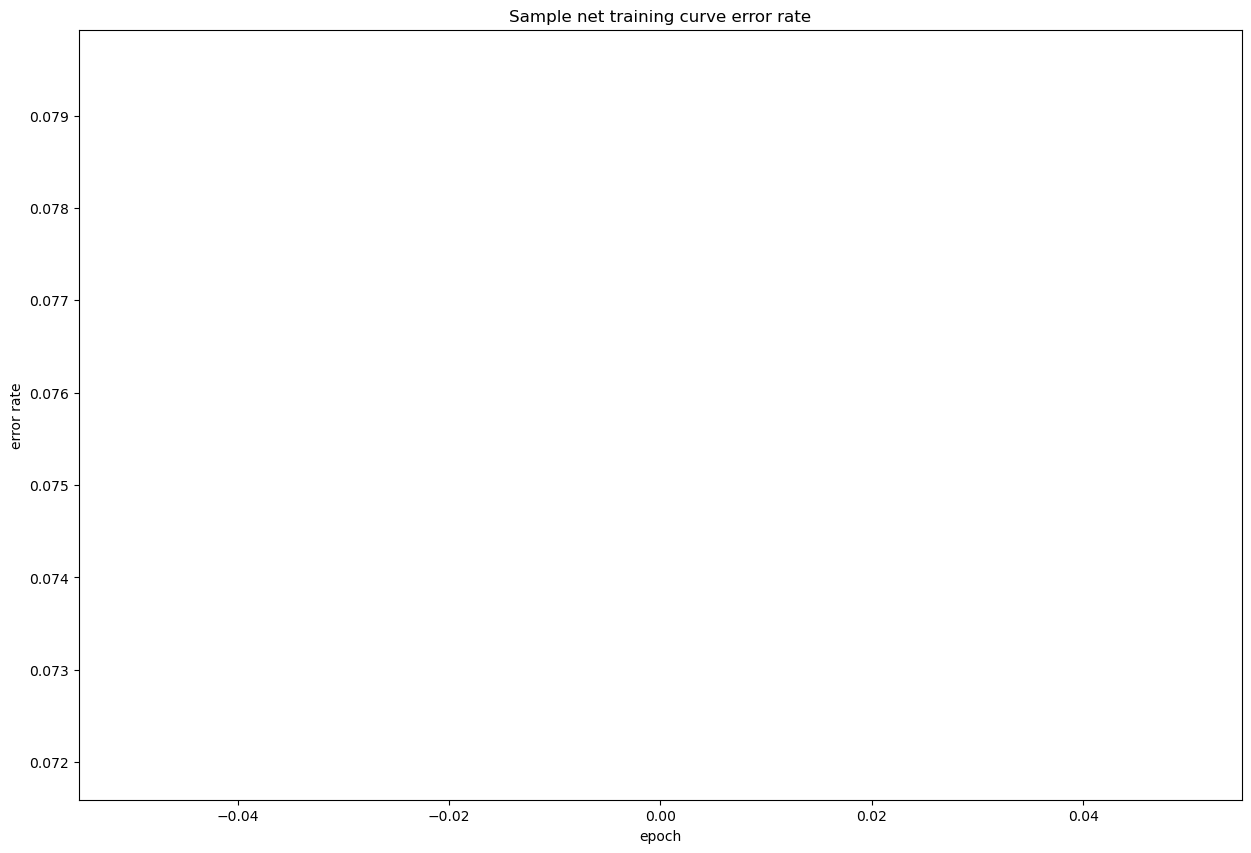

In [17]:
 # plot learning curve
plt.plot(History.history["loss"])
plt.title("Sample net training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(History.history["accuracy"]))
plt.title("Sample net training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

In [24]:
img=gdal.Open(r'D:\ml\image\3.tif')

In [26]:
transform=img.GetGeoTransform()

In [27]:
projection=img.GetProjection()

In [28]:
spatial_ref = osr.SpatialReference()

In [29]:
spatial_ref.ImportFromWkt(projection)
bands = [img.GetRasterBand(band+1) for band in range(img.RasterCount)]
listOfArrays = [band.ReadAsArray() for band in bands] 
image = np.array(listOfArrays)


In [30]:
image.shape

(3, 10000, 10000)

In [31]:
#height,width,band
image=image.transpose(1,2,0)

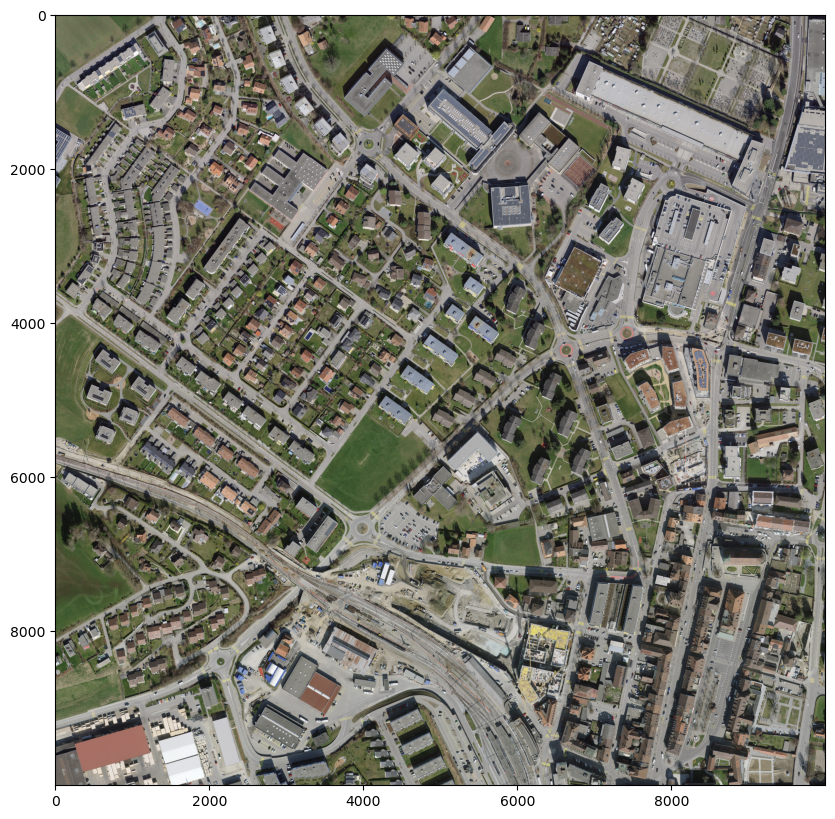

In [32]:
plt.imshow(image)

In [33]:
# Slice the image into 256 x 256 patches for prediction.

# Some variables.
patch_size = 256
overlap = 0.5

height, width, bands = image.shape
im_list, name_list, pos_list = [], [], [] 

pos_columns = ['name', 'xmin', 'ymin', 'patch_size', 'im_x', 'im_y']

seen_coords = set()
                
# Iterate through image and bin it up appropriately.
for x in range(0, width - 1, int(patch_size * (1 - overlap))):          # In this case, the stride is approx. 205 pixels.
    for y in range(0, height - 1, int(patch_size * (1 - overlap))):     # Same as above.
        
        xmin = min(x, width - patch_size)
        ymin = min(y, height - patch_size) 
        coords = (xmin, ymin)
        
        # check if we've already seen these coords
        if coords in seen_coords:
            # print ("coords already encountered (xmin, ymin):", coords)
            continue
        else:
            seen_coords.add(coords)
        
        # check if we screwed up binning
        if (xmin + patch_size > width) or (ymin + patch_size > height):
            print ("Oops. Improperly binned image.")
            continue

        # get image cutout
        im_cutout = image[ymin:ymin + patch_size, xmin:xmin + patch_size]
        
        # set slice name
        name = 'patch_x' + str(xmin) + '_y' + str(ymin) + '_sz' + str(patch_size) + '_w' + str(width) + '_h' + str(height)

        pos = [name, xmin, ymin, patch_size, width, height]

        # add to arrays
        name_list.append(name)
        im_list.append(im_cutout)
        pos_list.append(pos)

# convert to np arrays
name_out_arr = np.array(name_list)
im_out_arr = np.array(im_list)
pred_array = im_out_arr / 255.0

# create position datataframe
df_pos = pd.DataFrame(pos_list, columns=pos_columns)
df_pos.index = np.arange(len(df_pos))

In [34]:
print(pred_array.shape)

(6084, 256, 256, 3)


In [35]:
predictions = UNet.predict(pred_array,verbose=1) 

191/191 [==============================] - 838s 4s/step


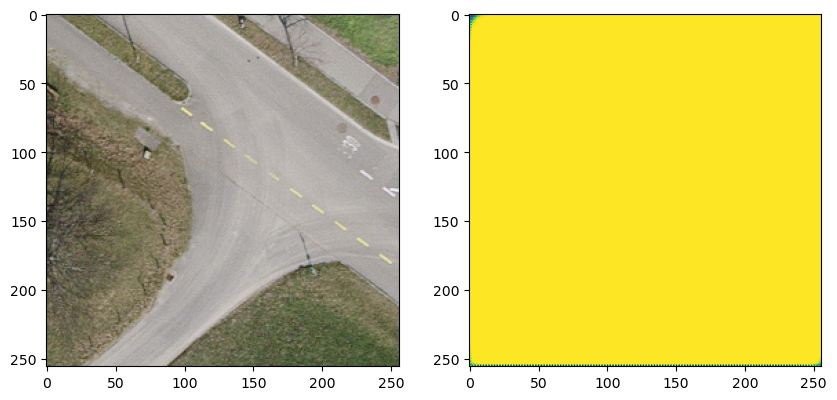

In [46]:
img_num = 29

orig = tf.squeeze(predictions[img_num])
prediction = pred_array[img_num]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(prediction)
plt.subplot(1,2,2)
plt.imshow(orig)

In [37]:
# Rebuild the predictions into a single image.

# For a dataframe of image positions (df_pos), and the tiles of that image
# (im_arr), reconstruct the image.

# Create numpy zeros of appropriate shape.
empty_img = np.zeros((height, width, 1))

# Create another zero array to record where pixels are overlaid.
overlay_count = np.zeros((height, width, 1))

# Iterate through patches.
for index, item in df_pos.iterrows():

    # Grab values for each row / patch. 
    [name, xmin, ymin, patch_slice, im_x, im_y] = item
    
    # Grab the right patch.
    img_slice = predictions[index]
        
    x0, x1 = xmin, xmin + patch_size
    y0, y1 = ymin, ymin + patch_size

    # Add img_slice to empty_img.
    empty_img[y0:y1, x0:x1] += img_slice

    # Update count of overlapping pixels.
    overlay_count[y0:y1, x0:x1] += np.ones((patch_size, patch_size, 1))
              
rebuilt_img = np.divide(empty_img, overlay_count)

(-0.5, 9999.5, 9999.5, -0.5)

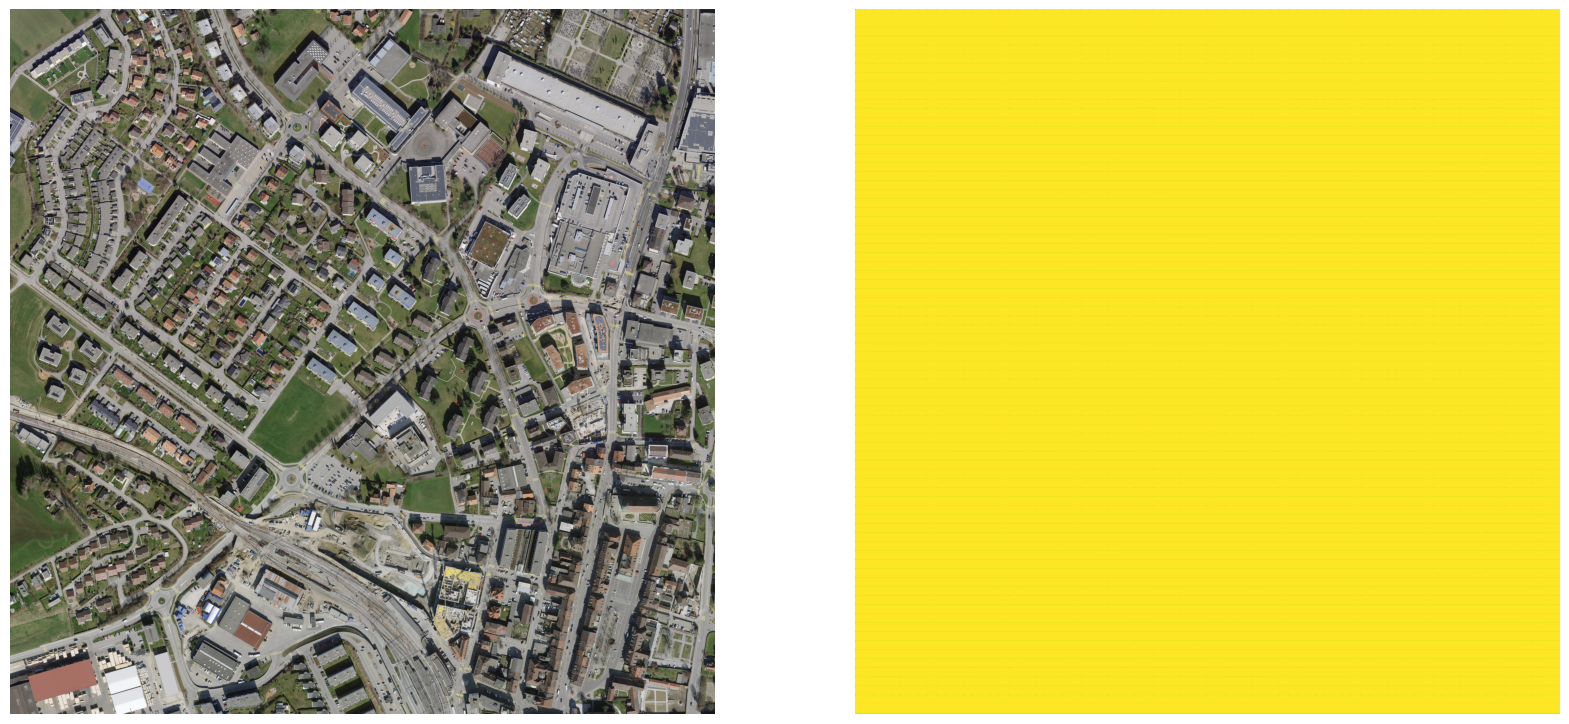

In [38]:
# This block is OPTIONAL; plot the original image next to the prediction mask.
plt.figure(figsize=(20, 20))

plt.subplot(1,2,1)
plt.imshow(tf.squeeze(image))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(rebuilt_img))
plt.axis('off')